In [1]:
# install required packages

import numpy as np 
import pandas as pd 
import os
import seaborn as sns
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from scipy import stats
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read database and store in a dataframe variable
def read(path='/kaggle/input/10000-amazon-products-dataset/Amazon_Products.csv'):
    df = pd.read_csv(path, dtype=str)
    display(df.head())
    return df

df = read()
df.shape

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category,description,...,Unnamed: 885,Unnamed: 886,Unnamed: 887,Unnamed: 888,Unnamed: 889,Unnamed: 890,Unnamed: 891,Unnamed: 892,Unnamed: 893,Unnamed: 894
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,Hornby,£3.42,5 new,15,1,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Product Description Hornby 2014 Catalogue Box ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,FunkyBuys,£16.99,NaN,2,1,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Size Name:Large FunkyBuys® Large Christmas Hol...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,ccf,£9.99,2 new,17,2,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e12b92dbb8eaee78b22965d2a9bbbd9f,HORNBY Coach R4410A BR Hawksworth Corridor 3rd,Hornby,£39.99,NaN,1,2,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e33a9adeed5f36840ccc227db4682a36,Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam...,Hornby,£32.19,NaN,3,2,4.7 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Product Description Hornby RailRoad 0-4-0 Gild...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(10004, 895)

## Data Cleaning

There are a wide variety of columns available in the dataset which will need to be looked at one at a time. Upon a quick look, it seems like most of the columns starting with "Unnamed" are not useful and can be deleted.

In [3]:
# function to summarize any column
def ColSummary (col, dtype=None, new_col=None):
    try:
        print("\n"+str(col).upper()+" ANALYSIS")
        if new_col:
            df.rename(columns={col:new_col})
            print("\t"+col+" name updated to "+new_col)
            col = new_col
        if dtype:
            df[col] = df[col].astype(dtype)
            print("\tType changed to "+dtype)
        print('\tTotal number of values : ', len(df[col]))
        print('\tTotal number of unique values : ', df[col].nunique())
        print('\tUnique values : ',df[col].unique()[:5])
        print('\tRange of length : ', min(df[col].apply(lambda x: len(str(x))))," to ",max(df[col].apply(lambda x: len(str(x)))))
        print('\tMissing Values : ', df[col].isna().sum())
    except:
        print("\n*** Cannot work with this datatype.. Try Again.... ***")

In [4]:
# delete columns which are unnamed
unnamed_cols = [col for col in df.columns if 'Unnamed' in col]
df = df.drop(unnamed_cols, axis = 1)
print("Leftover columns: ", df.columns)

Leftover columns:  Index(['uniq_id', 'product_name', 'manufacturer', 'price',
       'number_available_in_stock', 'number_of_reviews',
       'number_of_answered_questions', 'average_review_rating',
       'amazon_category_and_sub_category', 'description',
       'product_information', 'product_description',
       'items_customers_buy_after_viewing_this_item',
       'customer_questions_and_answers'],
      dtype='object')


In [5]:
# Analyze and clean Unique IDS (primary key)
ColSummary('uniq_id', 'str')
# Some IDs have unusual length
print('\n\tInspecting IDs with unusual length : ', list(df['uniq_id'][df['uniq_id'].apply(lambda x: len(str(x)))<=3]))
print('\tDeleting IDs with unusual length ..... ')
df = df.drop(index = list(df['uniq_id'][df['uniq_id'].apply(lambda x: len(str(x))<=3)].index))
print('\nUnique IDs updated .....')
ColSummary('uniq_id')


UNIQ_ID ANALYSIS
	Type changed to str
	Total number of values :  10004
	Total number of unique values :  10002
	Unique values :  ['eac7efa5dbd3d667f26eb3d3ab504464' 'b17540ef7e86e461d37f3ae58b7b72ac'
 '348f344247b0c1a935b1223072ef9d8a' 'e12b92dbb8eaee78b22965d2a9bbbd9f'
 'e33a9adeed5f36840ccc227db4682a36']
	Range of length :  1  to  32
	Missing Values :  0

	Inspecting IDs with unusual length :  ['nan', '}', 'nan', '}']
	Deleting IDs with unusual length ..... 

Unique IDs updated .....

UNIQ_ID ANALYSIS
	Total number of values :  10000
	Total number of unique values :  10000
	Unique values :  ['eac7efa5dbd3d667f26eb3d3ab504464' 'b17540ef7e86e461d37f3ae58b7b72ac'
 '348f344247b0c1a935b1223072ef9d8a' 'e12b92dbb8eaee78b22965d2a9bbbd9f'
 'e33a9adeed5f36840ccc227db4682a36']
	Range of length :  32  to  32
	Missing Values :  0


In [6]:
# Analyze Product Name - No cleaning required
ColSummary('product_name', 'string')


PRODUCT_NAME ANALYSIS
	Type changed to string
	Total number of values :  10000
	Total number of unique values :  9964
	Unique values :  <StringArray>
[                                                                                                 'Hornby 2014 Catalogue',
 'FunkyBuys® Large Christmas Holiday Express Festive Train Set (SI-TY1017) Toy Light / Sounds / Battery Operated & Smoke',
                                             'CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT ENGINE BOXED BOYS KIDS BATTERY',
                                                                         'HORNBY Coach R4410A BR Hawksworth Corridor 3rd',
                                                        'Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam Locomotive Model']
Length: 5, dtype: string
	Range of length :  3  to  536
	Missing Values :  0


In [7]:
# Analyze Manufacturer - No cleaning required
ColSummary('manufacturer', 'string') 


MANUFACTURER ANALYSIS
	Type changed to string
	Total number of values :  10000
	Total number of unique values :  2651
	Unique values :  <StringArray>
['Hornby', 'FunkyBuys', 'ccf', 'Generic', 'Chuggington']
Length: 5, dtype: string
	Range of length :  1  to  48
	Missing Values :  7


In [8]:
# Analyze Price - Need to convert string to numeric
ColSummary('price')

# Some rows have range mentioned instead of a price - this is significantly changing the df size
# another way to tackle this would be to add the middle point of the range as the prize
print("\n Deleting rows which have price with greater than 5 length i.e. have ranges instead of values .....")
df = df.drop(index = list(df['price'][df['price'].apply(lambda x: len(str(x))>5)].index))

# Remove the euro sign before numeric conversion
df['price'] = df['price'][df['price'].isna()==False].str[1:]

# Convert into float and analyze updated column
ColSummary('price', 'float64')


PRICE ANALYSIS
	Total number of values :  10000
	Total number of unique values :  2625
	Unique values :  ['£3.42' '£16.99' '£9.99' '£39.99' '£32.19']
	Range of length :  3  to  19
	Missing Values :  1435

 Deleting rows which have price with greater than 5 length i.e. have ranges instead of values .....

PRICE ANALYSIS
	Type changed to float64
	Total number of values :  5603
	Total number of unique values :  754
	Unique values :  [3.42 9.99 6.99  nan 9.6 ]
	Range of length :  3  to  4
	Missing Values :  1435


In [9]:
# Analyze Number available in stock - need to change to numeric 
ColSummary('number_available_in_stock')

# split the stings into list and keep only the numeric part
df['number_available_in_stock'] = df['number_available_in_stock'].apply(lambda x: str(x).split()[0])

# change to float and analyze again
ColSummary('number_available_in_stock','float64')


NUMBER_AVAILABLE_IN_STOCK ANALYSIS
	Total number of values :  5603
	Total number of unique values :  70
	Unique values :  ['5\xa0new' '2\xa0new' nan '1\xa0new' '18\xa0new']
	Range of length :  3  to  13
	Missing Values :  1532

NUMBER_AVAILABLE_IN_STOCK ANALYSIS
	Type changed to float64
	Total number of values :  5603
	Total number of unique values :  55
	Unique values :  [ 5.  2. nan  1. 18.]
	Range of length :  3  to  4
	Missing Values :  1532


In [10]:
# Analyze Number of Reviews - need to convert into numeric
ColSummary('number_of_reviews')

# some strings have commas which is preventing direct float conversion
print("\n Removing commas from strings for float conversion .....")
df['number_of_reviews'] = df['number_of_reviews'].apply(lambda x: str(x).replace(',',''))

# convert to float and analyze updated columns
ColSummary('number_of_reviews', 'float64')


NUMBER_OF_REVIEWS ANALYSIS
	Total number of values :  5603
	Total number of unique values :  157
	Unique values :  ['15' '17' '2' '8' '1']
	Range of length :  1  to  5
	Missing Values :  7

 Removing commas from strings for float conversion .....

NUMBER_OF_REVIEWS ANALYSIS
	Type changed to float64
	Total number of values :  5603
	Total number of unique values :  157
	Unique values :  [15. 17.  2.  8.  1.]
	Range of length :  3  to  6
	Missing Values :  7


In [11]:
# Analyze Number of Answered Questions - need to convert into numeric
ColSummary('number_of_answered_questions','float64')


NUMBER_OF_ANSWERED_QUESTIONS ANALYSIS
	Type changed to float64
	Total number of values :  5603
	Total number of unique values :  17
	Unique values :  [ 1.  2.  6. nan  5.]
	Range of length :  3  to  4
	Missing Values :  528


In [12]:
# Analyze Avg Review Ratign - need to convert into numeric
ColSummary('average_review_rating')

# the values include the denominator of the rating which is consistent throughtout and hence, need not be mentioned
df['average_review_rating'] = df['average_review_rating'].apply(lambda x: str(x).split()[0])

# After retaining only ratings and removing additional text, convert into float
ColSummary('average_review_rating', 'float64')


AVERAGE_REVIEW_RATING ANALYSIS
	Total number of values :  5603
	Total number of unique values :  17
	Unique values :  ['4.9 out of 5 stars' '3.9 out of 5 stars' '5.0 out of 5 stars'
 '4.8 out of 5 stars' '4.5 out of 5 stars']
	Range of length :  3  to  18
	Missing Values :  7

AVERAGE_REVIEW_RATING ANALYSIS
	Type changed to float64
	Total number of values :  5603
	Total number of unique values :  17
	Unique values :  [4.9 3.9 5.  4.8 4.5]
	Range of length :  3  to  3
	Missing Values :  7


In [13]:
# Analyze Categories - Each value has all the subcatogories mentioned in a string format - need to convert to list
ColSummary('amazon_category_and_sub_category')

# break using delimiter for list conversion
df['amazon_category_and_sub_category'] = df['amazon_category_and_sub_category'].apply(lambda x: str(x).split(" > "))

# each list has varied length, for easier analysis - make len consistent by adding None
itr = max(df['amazon_category_and_sub_category'].apply(lambda x: len(x)))
for i in range (1, itr+1):
    df['amazon_category_and_sub_category'].apply(lambda x: x.append("None") if (len(x) < i) else x)

# Analyze updated column
ColSummary('amazon_category_and_sub_category')


AMAZON_CATEGORY_AND_SUB_CATEGORY ANALYSIS
	Total number of values :  5603
	Total number of unique values :  220
	Unique values :  ['Hobbies > Model Trains & Railway Sets > Rail Vehicles > Trains'
 'Hobbies > Model Trains & Railway Sets > Lighting & Signal Engineering > Lamps & Lighting'
 'Hobbies > Model Trains & Railway Sets > Rail Vehicles > Locomotives'
 'Hobbies > Model Trains & Railway Sets > Lighting & Signal Engineering > Signal & Sound'
 'Hobbies > Model Trains & Railway Sets > Accessories > Recreational Activities']
	Range of length :  3  to  120
	Missing Values :  330

AMAZON_CATEGORY_AND_SUB_CATEGORY ANALYSIS
	Total number of values :  5603

*** Cannot work with this datatype.. Try Again.... ***


In [14]:
# Analyze description - no change required
ColSummary('description')


DESCRIPTION ANALYSIS
	Total number of values :  5603
	Total number of unique values :  4646
	Unique values :  ['Product Description Hornby 2014 Catalogue Box Contains 1 x one catalogue'
 'BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT ENGINE SOUND BOXED KIDS BATTERY Railway Train Set with Light Sound, Big Size Curved Track Free Wheeling Action Working Headlight Sound Horn The Track Can Also Be Assembled In More Layouts Length Of Track 104 cm WIDTH OF THE TRACK 68 CM Finely Detailed Realistic Toy Train REQUIRES 2 AA BATTERIES (NOT INCLUDED)'
 'These delicate model garden lights are mainly used in teaching, photography, and various kinds of scene model. Each of them is completed with wires and has double heads, which can be lighten with 6V power. These model lights measure about 7cm high. Light up your model layout with this great model lamppost! Description: A pack of 20pcs model garden lamps Each has double head, completed with wires and bulbs Mainly used to decorate your model layout

In [15]:
# Analyze Product Information - no change required
ColSummary('product_information')


PRODUCT_INFORMATION ANALYSIS
	Total number of values :  5603
	Total number of unique values :  5575
	Unique values :  ['Technical Details Item Weight640 g Product Dimensions29.6 x 20.8 x 1 cm Manufacturer recommended age:6 years and up Item model numberR8148 Main Language(s)English manual, English Number of Game Players1 Number of Puzzle Pieces1 Assembly RequiredNo Scale1:72 Engine Typeelectric Track Width/GaugeHO Batteries Required?No Batteries Included?No Material Type(s)Paper Material Care InstructionsNo Remote Control Included?No Radio Control Suitabilityindoor Colorwhite \xa0\xa0 Additional Information ASINB00HJ208KO Best Sellers Rank 52,854 in Toys & Games (See top 100) #69 in\xa0Toys & Games > Model Trains & Railway Sets > Rail Vehicles > Trains Shipping Weight640 g Delivery Destinations:Visit the Delivery Destinations Help page to see where this item can be delivered. Date First Available24 Dec. 2013 \xa0\xa0 Feedback \xa0Would you like to update product info or give feedback 

In [16]:
# Analyze Product Description - no change required

# the values look similar to description column - this column might not add much value 
ColSummary('product_description')


PRODUCT_DESCRIPTION ANALYSIS
	Total number of values :  5603
	Total number of unique values :  4645
	Unique values :  ['Product Description Hornby 2014 Catalogue Box Contains 1 x one catalogue'
 'BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT ENGINE SOUND BOXED KIDS BATTERY Railway Train Set with Light Sound, Big Size Curved Track Free Wheeling Action Working Headlight Sound Horn The Track Can Also Be Assembled In More Layouts Length Of Track 104 cm WIDTH OF THE TRACK 68 CM Finely Detailed Realistic Toy Train REQUIRES 2 AA BATTERIES (NOT INCLUDED)'
 'These delicate model garden lights are mainly used in teaching, photography, and various kinds of scene model. Each of them is completed with wires and has double heads, which can be lighten with 6V power. These model lights measure about 7cm high. Light up your model layout with this great model lamppost! Description: A pack of 20pcs model garden lamps Each has double head, completed with wires and bulbs Mainly used to decorate your mode

In [17]:
# Analyze URLs of the next bought product 

ColSummary('items_customers_buy_after_viewing_this_item')


ITEMS_CUSTOMERS_BUY_AFTER_VIEWING_THIS_ITEM ANALYSIS
	Total number of values :  5603
	Total number of unique values :  3768
	Unique values :  ['http://www.amazon.co.uk/Hornby-R8150-Catalogue-2015/dp/B00S9SUUBE | http://www.amazon.co.uk/Hornby-Book-Model-Railways-Edition/dp/1844860957 | http://www.amazon.co.uk/Peco-60-Plans-Book/dp/B002QVL16I | http://www.amazon.co.uk/Newcomers-Guide-Model-Railways-Step/dp/1857943295'
 'http://www.amazon.co.uk/Train-With-Tracks-Battery-Operated-x/dp/B009P540O8 | http://www.amazon.co.uk/Classic-Train-Lights-Battery-Operated/dp/B0041L9OHE | http://www.amazon.co.uk/Train-Flash-Electric-Sound-Europe/dp/B008D7CEH4 | http://www.amazon.co.uk/13-Piece-Train-Set-Ideal/dp/B0173N6E4W'
 'http://www.amazon.co.uk/Single-Head-Garden-Lights-Lamppost-Layout/dp/B008XCSHCA | http://www.amazon.co.uk/Model-Scene-Gas-Lamp-Posts/dp/B006MGB90G | http://www.amazon.co.uk/12pcs-1-2-inch-Scenery-Landscape/dp/B008S8NHYM | http://www.amazon.co.uk/douself-100Pcs-OO-Scale-Passenger/d

In [18]:
# Analyze customer Qs 
ColSummary('customer_questions_and_answers')

# There are a lot of missing values in this column
# This is not unusual as customers might not have questions about each product


CUSTOMER_QUESTIONS_AND_ANSWERS ANALYSIS
	Total number of values :  5603
	Total number of unique values :  374
	Unique values :  ['Does this catalogue detail all the previous Hornby products please? // HiThe 2014 catalogue does indeed detail previous models but also includes new releases for 2014.You would be advised to purchase models as you need them to avoid them being discontinued in subsequent years…\n    \n      see more\n    \n  \n  \n    HiThe 2014 catalogue does indeed detail previous models but also includes new releases for 2014.You would be advised to purchase models as you need them to avoid them being discontinued in subsequent yearsHope this helps\n    \n      see less'
 "What is the gauge of the track // Hi Paul.Truthfully, I'm not sure. But it's very much alike to a 00 gauge. But this train set isn't an add-on for an electric train set nor has nothing to do with one.I bought this for my 4 year old nephew as he adores trains but is far too young for an electric set. He 

In [19]:
# Final df shape after cleaning
df.shape

(5603, 14)

## Exploratory Data Analysis (EDA)
After cleaning the data, we can run some exploratory analysis to understand the data better. I am going to simply follow my curiousity here.

<font color = 'blue'>
<h2> Question 1. What are the most popular brands? </h2>

There are multiple ways to define "popular". I'm going to explore 3 ways here:
<ul>
    <li>Number of products sold</li>
<li>Total sales by price </li>
<li>Highest rated products </li>
    </ul>

In [20]:
# number of products sold

df[['product_name','manufacturer']].groupby('manufacturer').count().sort_values(by = "product_name", ascending = False)

,product_name
manufacturer,
Oxford Diecast,97
Disney,95
MyTinyWorld,92
LEGO,70
Mattel,69
...,...
JR Propo,1
JJS Direct UK,1
J R Jigsaws,1


In [21]:
# Total sales by price

df[['price','manufacturer']].groupby('manufacturer').sum().sort_values(by = "price", ascending = False)

,price
manufacturer,
Oxford Diecast,630.99
Disney,383.87
LEGO,273.77
MyTinyWorld,265.21
Papo,250.12
...,...
Fundex,0.00
Spektrum,0.00
Specialist,0.00


In [22]:
# highest rated

ratings_df = df[['average_review_rating', 'number_of_reviews','manufacturer']].groupby('manufacturer').agg({'average_review_rating':'mean', 'number_of_reviews': "sum"
                                                                                      }).sort_values(by = ["average_review_rating","number_of_reviews"], ascending = False)
ratings_df

,average_review_rating,number_of_reviews
manufacturer,,
Dodolive,5.0,13.0
Teddy Hermann,5.0,12.0
BSP,5.0,11.0
Elizabeth Arden,5.0,10.0
Kato,5.0,10.0
...,...,...
Cavendish Trading,3.3,3.0
BINGWAN,3.0,2.0
Inflatable Santa,3.0,2.0


In [23]:
# checking number of manufacturers with 5 rating
print("\n Brands with perfect 5 rating:", len(ratings_df[ratings_df["average_review_rating"]==5.0]))

# checking number of 5-rated manufactureres which have > 5 number of reviews      
print("\n Brands with perfect 5 rating and substantial number of reviews:",
      len(ratings_df[ratings_df["average_review_rating"]==5.0][ratings_df[ratings_df["average_review_rating"]==5.0]
                                                               ["number_of_reviews"]>5]),"\n\n")


 Brands with perfect 5 rating: 669

 Brands with perfect 5 rating and substantial number of reviews: 22 




<font color = 'blue'>
    <h3> Results </h3>

- Oxford Diecast, Disney and MyTinyWorld have sold the most products
- Oxfort Diecast has had the highest sales by far almost double the second highest
- 669 manufacturers have perfect 5 rating but only 22 have been rated 5 on average by 5 or more customers

***


<font color = 'blue'>
<h2> Question 2. What are some keywords that are repeatedly used by brands in descriptions? </h2>

In [24]:
def show_wordcloud(data, title = None):
    stopwords = set(STOPWORDS)
    mask = np.array(Image.open("../input/amazon/amazon.png"))
    wordcloud = WordCloud(
        background_color='white',
        stopwords = stopwords,
        mask = mask,
        max_words=200,
        max_font_size=40, 
        scale=1,
        random_state=1
).generate(" ".join(data))

    fig = plt.figure(1, figsize=(25, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

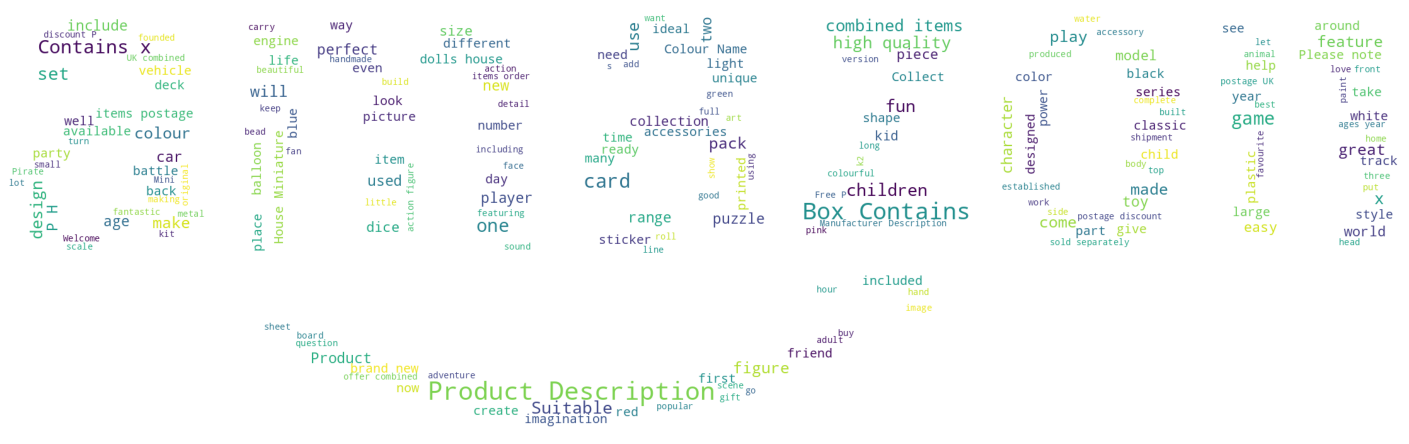

In [25]:
col = 'description'
wordcloud_df = df[df[col].notna()]
show_wordcloud(wordcloud_df[col].values)

<font color = 'blue'>
    <h3> Results </h3>

Some interesting words repeated across descriptions are: Suitable, high quality, classic, great, feature, card

***

<font color = 'blue'>
<h2> Question 3. Predict the amazon categories using description? </h2>

In [26]:
def TextClassifier(text_data,label):
    "function to create text classifier for a set of data and labels"
    text_clf = Pipeline([ ('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),('clf', MultinomialNB())])
    text_clf = text_clf.fit(text_data, label)
    return text_clf

In [27]:
# defining the target variable

df['category'] = df['amazon_category_and_sub_category'].apply(lambda x: x[0])

categorytolabel = {}
i = 1
for item in df['category'].unique():
    categorytolabel[item] = i
    i = i+1

df['category_labels'] = df['category'].map(categorytolabel)

df = df.groupby('category').filter(lambda x : len(x)>30)
df = df.drop(index = list(df[df['category']=='nan'].index))

In [28]:
# running the model and comparing the predictions
text_df = df[['product_information','product_description']]

for col in text_df.columns:
    text_df[col] = text_df[col].fillna(value='None')
    model = TextClassifier(text_df[col],df['category_labels'])
    text_df[col+'_classification'] = model.predict(text_df[col])

text_df['product_information_classification'] = text_df['product_information_classification'].map({value : key for (key, value) in categorytolabel.items()})
text_df['product_description_classification'] = text_df['product_description_classification'].map({value : key for (key, value) in categorytolabel.items()})
df = df.merge(text_df[['product_information_classification','product_description_classification']], how = 'left', left_index = True, right_index = True)


from sklearn.metrics import classification_report
print("\n\n ********* CLASSIFICATION ACCURACY BASED ON PRODUCT INFORMATION *********")
print("\n", classification_report(df['category'], df['product_information_classification'] ))
print("\n\n ********* CLASSIFICATION ACCURACY BASED ON PRODUCT DESCRIPTION *********")
print("\n", classification_report(df['category'], df['product_description_classification'] ))



 ********* CLASSIFICATION ACCURACY BASED ON PRODUCT INFORMATION *********

                            precision    recall  f1-score   support

            Arts & Crafts       0.90      0.98      0.94       652
      Baby & Toddler Toys       0.00      0.00      0.00        59
      Characters & Brands       0.52      0.17      0.26       503
  Die-Cast & Toy Vehicles       1.00      0.27      0.42       498
      Dolls & Accessories       0.99      0.59      0.74       254
              Fancy Dress       1.00      0.42      0.59       348
       Figures & Playsets       0.68      0.84      0.76       541
                    Games       0.49      0.97      0.65       611
                  Hobbies       0.52      0.85      0.64       654
        Jigsaws & Puzzles       0.00      0.00      0.00       157
           Party Supplies       0.72      0.99      0.84       662
Puppets & Puppet Theatres       0.00      0.00      0.00        71
    Sports Toys & Outdoor       1.00      0.01    

<font color = "blue">
<h3>Results</h3>
Product Description is a better predictor of amazon category compared to product information

***